In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from individual_players.league_model import (
    add_opponent,
    fit_std_by_sample_size,
)
from individual_players import LeagueModel, build_combined_df, callbacks, update_loop
from pathlib import Path

In [3]:
league = "mens"
performances = build_combined_df(league, verbose=False)
performances = add_opponent(performances)

In [4]:
model = LeagueModel.load(str(Path("models", f"{league}_league.pkl")))
performances = performances.assign(
    vpp_sd=model.possessions_to_vpp_std(performances.n_possessions)
)
performances = performances.sort_values("game_id")
defense_model = LeagueModel.load(str(Path("models", f"{league}_league_defense.pkl")))
performances = performances.assign(
    vpp_sd=model.possessions_to_vpp_std(performances.n_possessions),
    defense_sd=defense_model.possessions_to_vpp_std(performances.n_possessions),
)
defense_callback = callbacks.DefenseAdjustingCallback(defense_model)
_ = update_loop(
    performances,
    model,
    [defense_callback.team_callback],
    [defense_callback.player_callback],
)


100%|██████████| 67029/67029 [07:56<00:00, 140.74it/s]


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from individual_players.league_model import add_player_aggregates

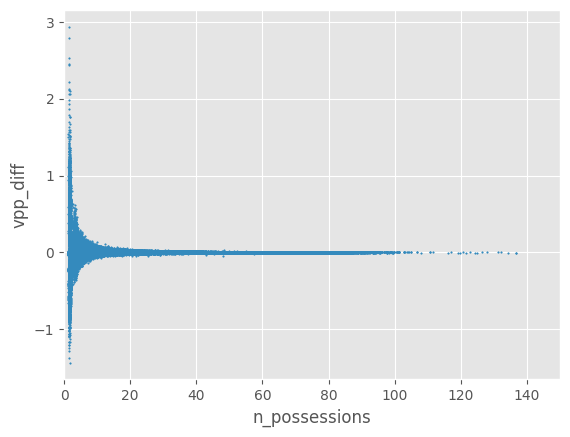

In [8]:
with_player_aggregates, by_player = add_player_aggregates(defense_callback.adjusted_performances)
with_player_aggregates.plot.scatter('n_possessions', 'vpp_diff', s=1)
# There's values hidden both below and above this...might want to strip them out
plt.xlim(0, 150);

Neat, looks like something around 1/x. Transform that so I can make a linear model

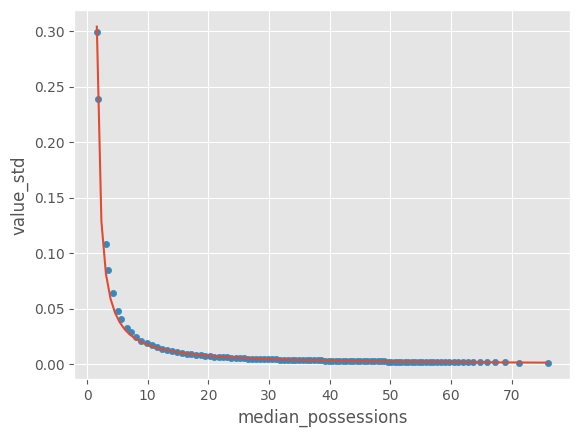

In [9]:
std_by_sample_size, get_vpp_sd = fit_std_by_sample_size(with_player_aggregates, inv_power=1, polynomial_power=2)
std_by_sample_size.plot.scatter('median_possessions', 'value_std');

# Draw the curve of our fit
x = np.linspace(std_by_sample_size.median_possessions.min(), std_by_sample_size.median_possessions.max(), 100)
line_result = get_vpp_sd(x)
plt.plot(x, line_result);

Seems like a pretty good fit. Let's use that

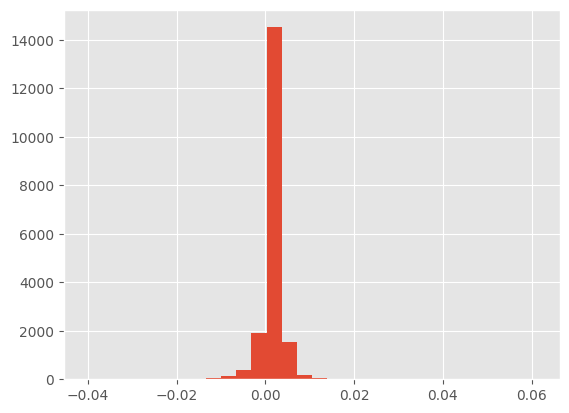

In [10]:
career_vpp = (by_player.total_value / by_player.total_possessions)
career_vpp.hist(bins=30);

In [11]:
vpp_mean = career_vpp.mean()
vpp_var = career_vpp.var()
print(f"{vpp_mean = }\n{vpp_var = }")

vpp_mean = 0.0017910375530975334
vpp_var = 8.447952076886844e-06


In [12]:
model = LeagueModel(
    possessions_to_vpp_std=get_vpp_sd,
    vpp_mean=vpp_mean,
    vpp_variance=vpp_var,
)
model.save(f"models/{league}_league_adjusted.pkl")